# Taxi ride prediction

A Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction. 

The RMSE metric on the test set should not be more than 48.

**Description of the data**:

- num_orders - Number of orders
- datetime - Date of ride

**Answer these questions**:
- Download the data and resample it by one hour.
- Analyze the data.
- Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
- Test the data using the test sample and provide a conclusion.




## Data description

Import the main libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Import the data set.

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Check that the index is monotonic.

In [4]:
data.index.is_monotonic

True

## Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


The data set contains 26496 terms, the data in the dataset is for the period from March 1, 2018 to August 31, 2018.
<br> The minimum number of orders in 10 minutes is 0, the maximum is 119. 
<br> On average, a taxi is ordered 84 times in 10 minutes.

Resample the data by an hour.

In [7]:
data = data.resample('1H').sum()

display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Build a graph of the initial data on which the variance and the moving average for the period of 24 hours is displayed.

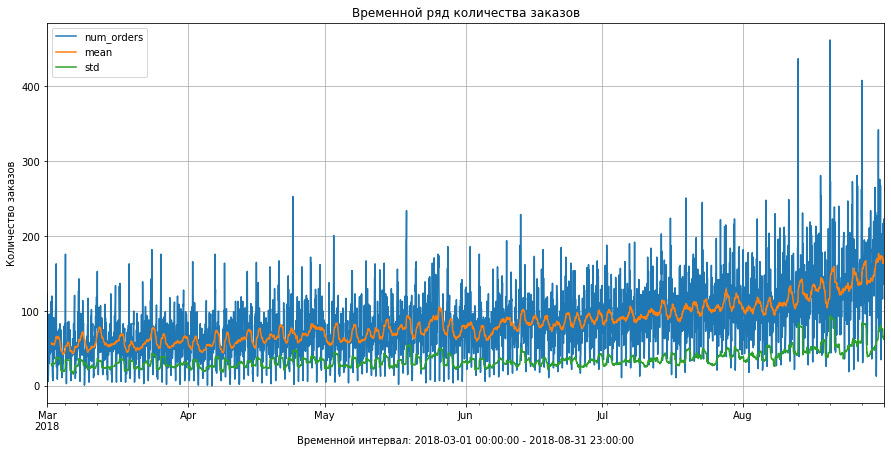

In [8]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()

data.plot(figsize=(15, 7))
plt.grid()
plt.xlabel("Временной интервал: %s - %s" %
               (data.index.min(), data.index.max()))
plt.ylabel('Количество заказов')
plt.title('Временной ряд количества заказов')
plt.show()

The chart shows peak loads, an increasing trend, increasing variance by the end of August.
It is difficult to observe seasonality.

Explore the data for the last month.

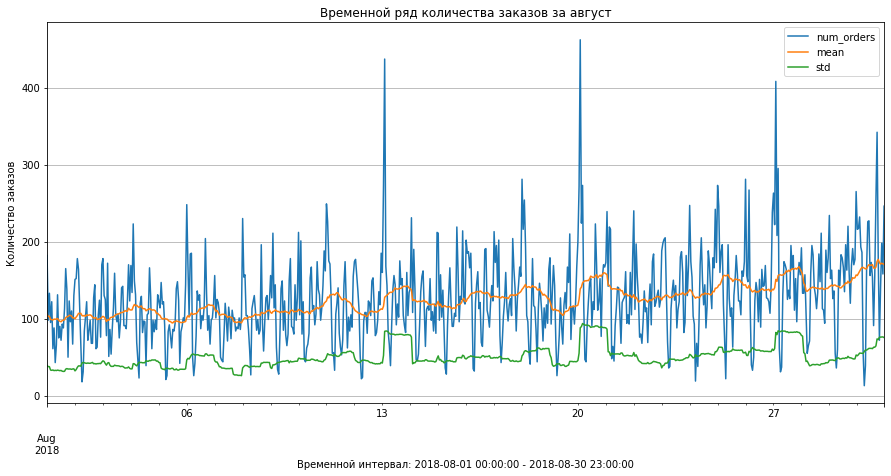

In [9]:
data_aug = data['2018-08-01':'2018-08-30']

data_aug.plot(figsize=(15, 7))
plt.grid()
plt.xlabel("Временной интервал: %s - %s" %
               (data_aug.index.min(), data_aug.index.max()))
plt.ylabel('Количество заказов')
plt.title('Временной ряд количества заказов за август')
plt.show()

The graph reveals weekly seasonality.

Check if the number of orders changes during the day using the example of three days in August.

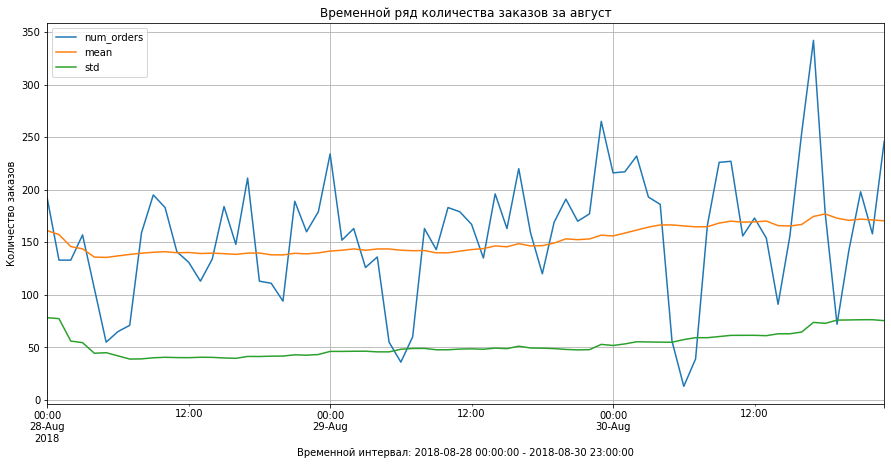

In [10]:
data_aug_week = data['2018-08-28':'2018-08-30']

data_aug_week.plot(figsize=(15, 7))
plt.grid()
plt.xlabel("Временной интервал: %s - %s" %
               (data_aug_week.index.min(), data_aug_week.index.max()))
plt.ylabel('Количество заказов')
plt.title('Временной ряд количества заказов за август')
plt.show()

The chart shows seasonality within the day (decrease around 6 am, then an increase by about 10 am, which can be explained by trips to work on weekdays, one of the peaks around 17 pm may be associated with ordering a taxi to return from work, there is also an increase in the number of trips after 19.00).

Decompose the initial data into trend, seasonality and residuals.

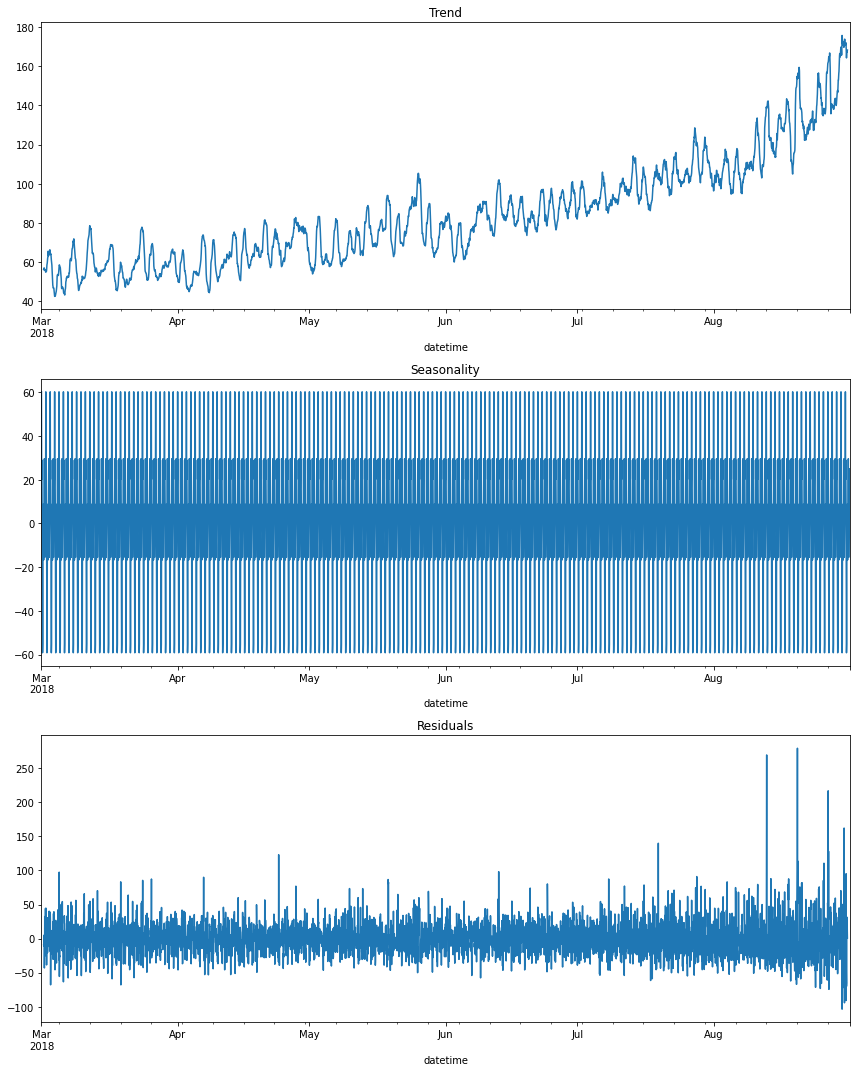

In [11]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Throughout the entire period, we observe a growing trend in the number of orders, it is difficult to draw any conclusions from the seasonality graph, the variance of balances increases in August.

Look at the data on the trend, seasonality and balances for the month of August.

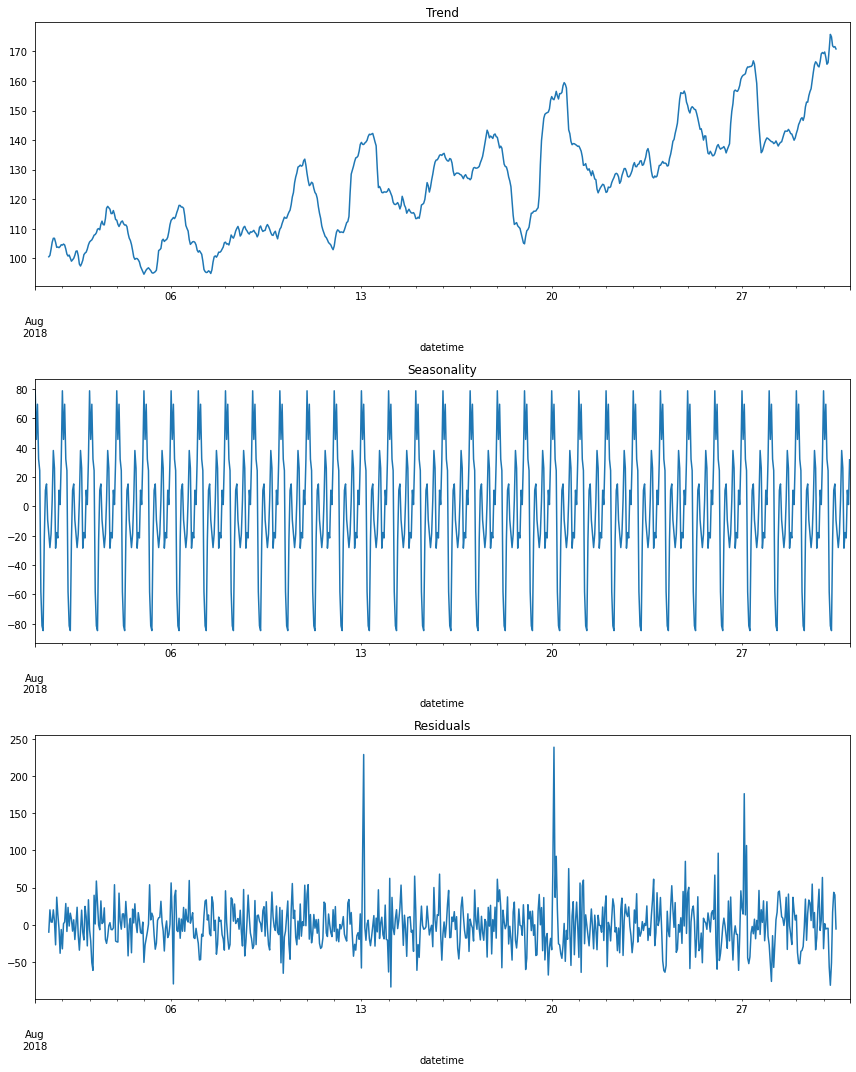

In [12]:
decomposed = seasonal_decompose(data['num_orders']['2018-08-01':'2018-08-30'])

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

The seasonality chart shows the seasonality by day.

Build an autocorrelation graph to determine the size of the moving average and the number of signs.

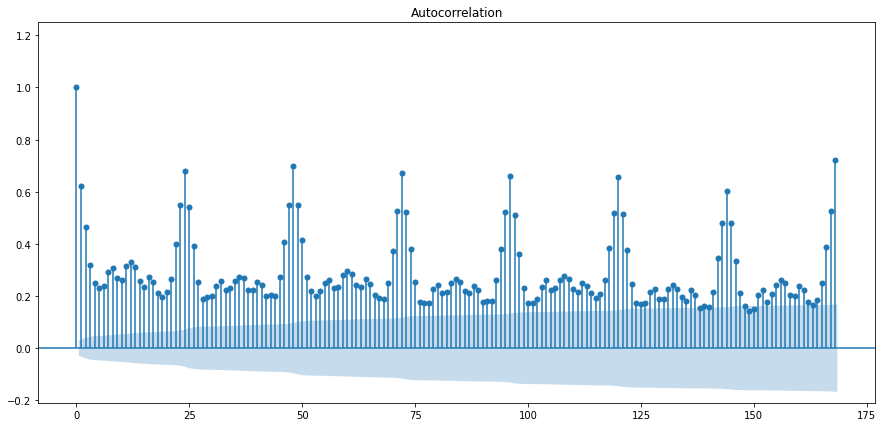

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
plot_acf(data['num_orders'], ax=ax, lags=24*7, auto_ylims=True);


The highest correlation coefficients are for the 24-hour interval.

### Conclusion

Main observations made after analysing the data:

- increasing trend for monthly orders
- seasonality by day (the number of orders depends on the time of day)
- seasonality by week (the number of orders depends on the day of the week)

Based on the autocorrelation graph, we will choose a value for the moving average equal to 24, to create features, we will take a lag of 24 * 7 (data for the week).

## Training and testing

Remove previously created columns with moving average and standard deviation from the dataset.

In [14]:
data = data.drop(['mean','std'], axis=1)

Create features for model training.

In [15]:
def make_features (data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1,max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data,168,24)

data = data.dropna()

data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


Split the samples into training, validation and test.

In [16]:
train, other = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(other, shuffle=False, test_size=0.5)
train.shape, valid.shape, test.shape

((3398, 172), (425, 172), (425, 172))

Create target and features.

In [16]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_valid = valid['num_orders']
features_valid = valid.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test= test.drop('num_orders', axis=1)



Create the formula for calculating the RMSE metric.

In [17]:
def rmse (target, predict):
    return (mean_squared_error(target, predict)) ** 0.5

Train a Linear regression model.

In [18]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid) 
result = rmse(target_valid,predictions_lr)

results = []
results.append({'Model': 'LinearRegression', 
                'Parameters': '', 
                'RMSE': result})

pd.DataFrame(results)

,Model,Parameters,RMSE
0,LinearRegression,,29.183057


Select the parameters and train the Random Forest model.

In [19]:
model_rfr = RandomForestRegressor(random_state=12345,max_depth=9, n_estimators=90)

#tscv = TimeSeriesSplit(n_splits=3)                            
#parameters_grid = {'n_estimators': range(0, 100, 10), 'max_depth': range(1,10)}         
#grid = GridSearchCV(estimator=model_rfr, param_grid = parameters_grid, cv=tscv)
#grid.fit(features_train, target_train)
#grid.best_params_
# Лучшие параметры: {'max_depth': 9, 'n_estimators': 90}


model_rfr.fit(features_train, target_train)
predictions_rfr = model_rfr.predict(features_valid)
result = rmse(target_valid,predictions_rfr)

results.append({'Model': 'RandomForestRegressor', 
               'Parameters': 'max_depth:  9, n_estimators: 90', 
               'RMSE': result})

pd.DataFrame(results)


,Model,Parameters,RMSE
0,LinearRegression,,29.183057
1,RandomForestRegressor,"max_depth: 9, n_estimators: 90",31.104147


Select the parameters and train the LightGBM model.

In [20]:
model_lgbmr = LGBMRegressor(random_state = 12345,learning_rate=0.1, max_depth=2, n_estimators=60)  

#tscv = TimeSeriesSplit(n_splits=3)                            
#parameters_grid = {'n_estimators': range(10,100,10),'max_depth' : range(1,10),'learning_rate': [0.1,0.3,0.5]}       
#grid = GridSearchCV(estimator=model_lgbmr, param_grid = parameters_grid, cv=tscv)
#grid.fit(features_train, target_train)
#grid.best_params_
#Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}



model_lgbmr.fit(features_train, target_train)
predictions_lgbmr = model_lgbmr.predict(features_valid)
result = rmse(target_valid,predictions_lgbmr)

results.append({'Model': 'LGBMRegressor', 
                'Parameters': 'learning_rate: 0.1, max_depth: 2, n_estimators: 60', 
             'RMSE': result})

pd.DataFrame(results)




,Model,Parameters,RMSE
0,LinearRegression,,29.183057
1,RandomForestRegressor,"max_depth: 9, n_estimators: 90",31.104147
2,LGBMRegressor,"learning_rate: 0.1, max_depth: 2, n_estimators...",30.849909


Select the parameters and train the Catboost model. 

In [21]:
model_catbr = CatBoostRegressor(random_state = 12345, loss_function = 'RMSE', verbose=10,depth=3, iterations=90, learning_rate=0.1)  

#tscv = TimeSeriesSplit(n_splits=3)                            
#parameters_grid = {'iterations': range(10,100,10),'depth' : range(1,10),'learning_rate': [0.1,0.3,0.5]}       
#grid = GridSearchCV(estimator=model_catbr, param_grid = parameters_grid, cv=tscv)
#grid.fit(features_train, target_train)
#grid.best_params_
#Лучшие параметры {'depth': 3, 'iterations': 90, 'learning_rate': 0.1}


model_catbr.fit(features_train, target_train)
predictions_catbr = model_catbr.predict(features_valid)
result = rmse(target_valid,predictions_catbr)

results.append({'Model': 'CatBoostRegressor', 
              'Parameters': 'depth: 7, iterations: 90, learning_rate: 0.1', 
               'RMSE': result})

pd.DataFrame(results)

0:	learn: 34.1123971	total: 60.1ms	remaining: 5.35s
10:	learn: 24.3993549	total: 157ms	remaining: 1.13s
20:	learn: 21.3818274	total: 255ms	remaining: 837ms
30:	learn: 20.3796069	total: 358ms	remaining: 682ms
40:	learn: 19.8828269	total: 467ms	remaining: 558ms
50:	learn: 19.6533388	total: 559ms	remaining: 427ms
60:	learn: 19.4658968	total: 653ms	remaining: 311ms
70:	learn: 19.2736716	total: 743ms	remaining: 199ms
80:	learn: 19.1110094	total: 837ms	remaining: 93ms
89:	learn: 18.9621002	total: 923ms	remaining: 0us


,Model,Parameters,RMSE
0,LinearRegression,,29.183057
1,RandomForestRegressor,"max_depth: 9, n_estimators: 90",31.104147
2,LGBMRegressor,"learning_rate: 0.1, max_depth: 2, n_estimators...",30.849909
3,CatBoostRegressor,"depth: 7, iterations: 90, learning_rate: 0.1",31.016361


The best RMSE result was shown by the Linear Regression model.

Сheck the rmse value for the Linear Regression model on a test sample.

In [22]:
predictions_test = model_lr.predict(features_test)
result = rmse(target_test,predictions_test)
print(result)

34.62782611997757


Retraining of the model is observed, the result of rmse < 48 is achieved.

Compare the RMSE indicator of the LightGBM model with the RMSE indicator using the previous value of the series.

In [23]:
pred_previous = target_test.shift(fill_value=target_valid.iloc[-1])
print(rmse(target_test,pred_previous))

58.819724582830204


RMSE is higher when using the previous value of the series.

Create prediction graphs with the Linear Regression model and the test set

In [24]:
predictions_test = pd.Series(predictions_test, index=target_test.index)
pred_previous = pd.Series(pred_previous, index=target_test.index)

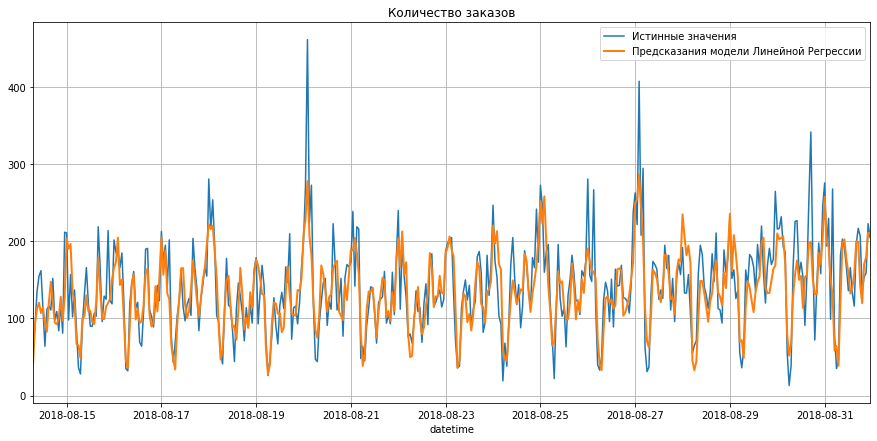

In [25]:
plt.figure(figsize=(15,7))
sns.lineplot(y=target_test.values, x=target_test.index)
sns.lineplot(y=predictions_test.values, x=predictions_test.index, linewidth=2)
plt.grid()
plt.xlim(target_test.index.min(), target_test.index.max())
plt.legend(['Истинные значения', 'Предсказания модели Линейной Регрессии'])
plt.title('Количество заказов');


The graph shows that, in general, the model predicts the number of orders quite well, but the model misses some peaks.

## Conclusion

During the project, a time series dataset with the number of taxi orders was explored, the data was analyzed and the trend, seasonality, and residuals were revealed.

4 regression models were trained and based on the results of the RMSE indicator, a Linear Regression model was selected.